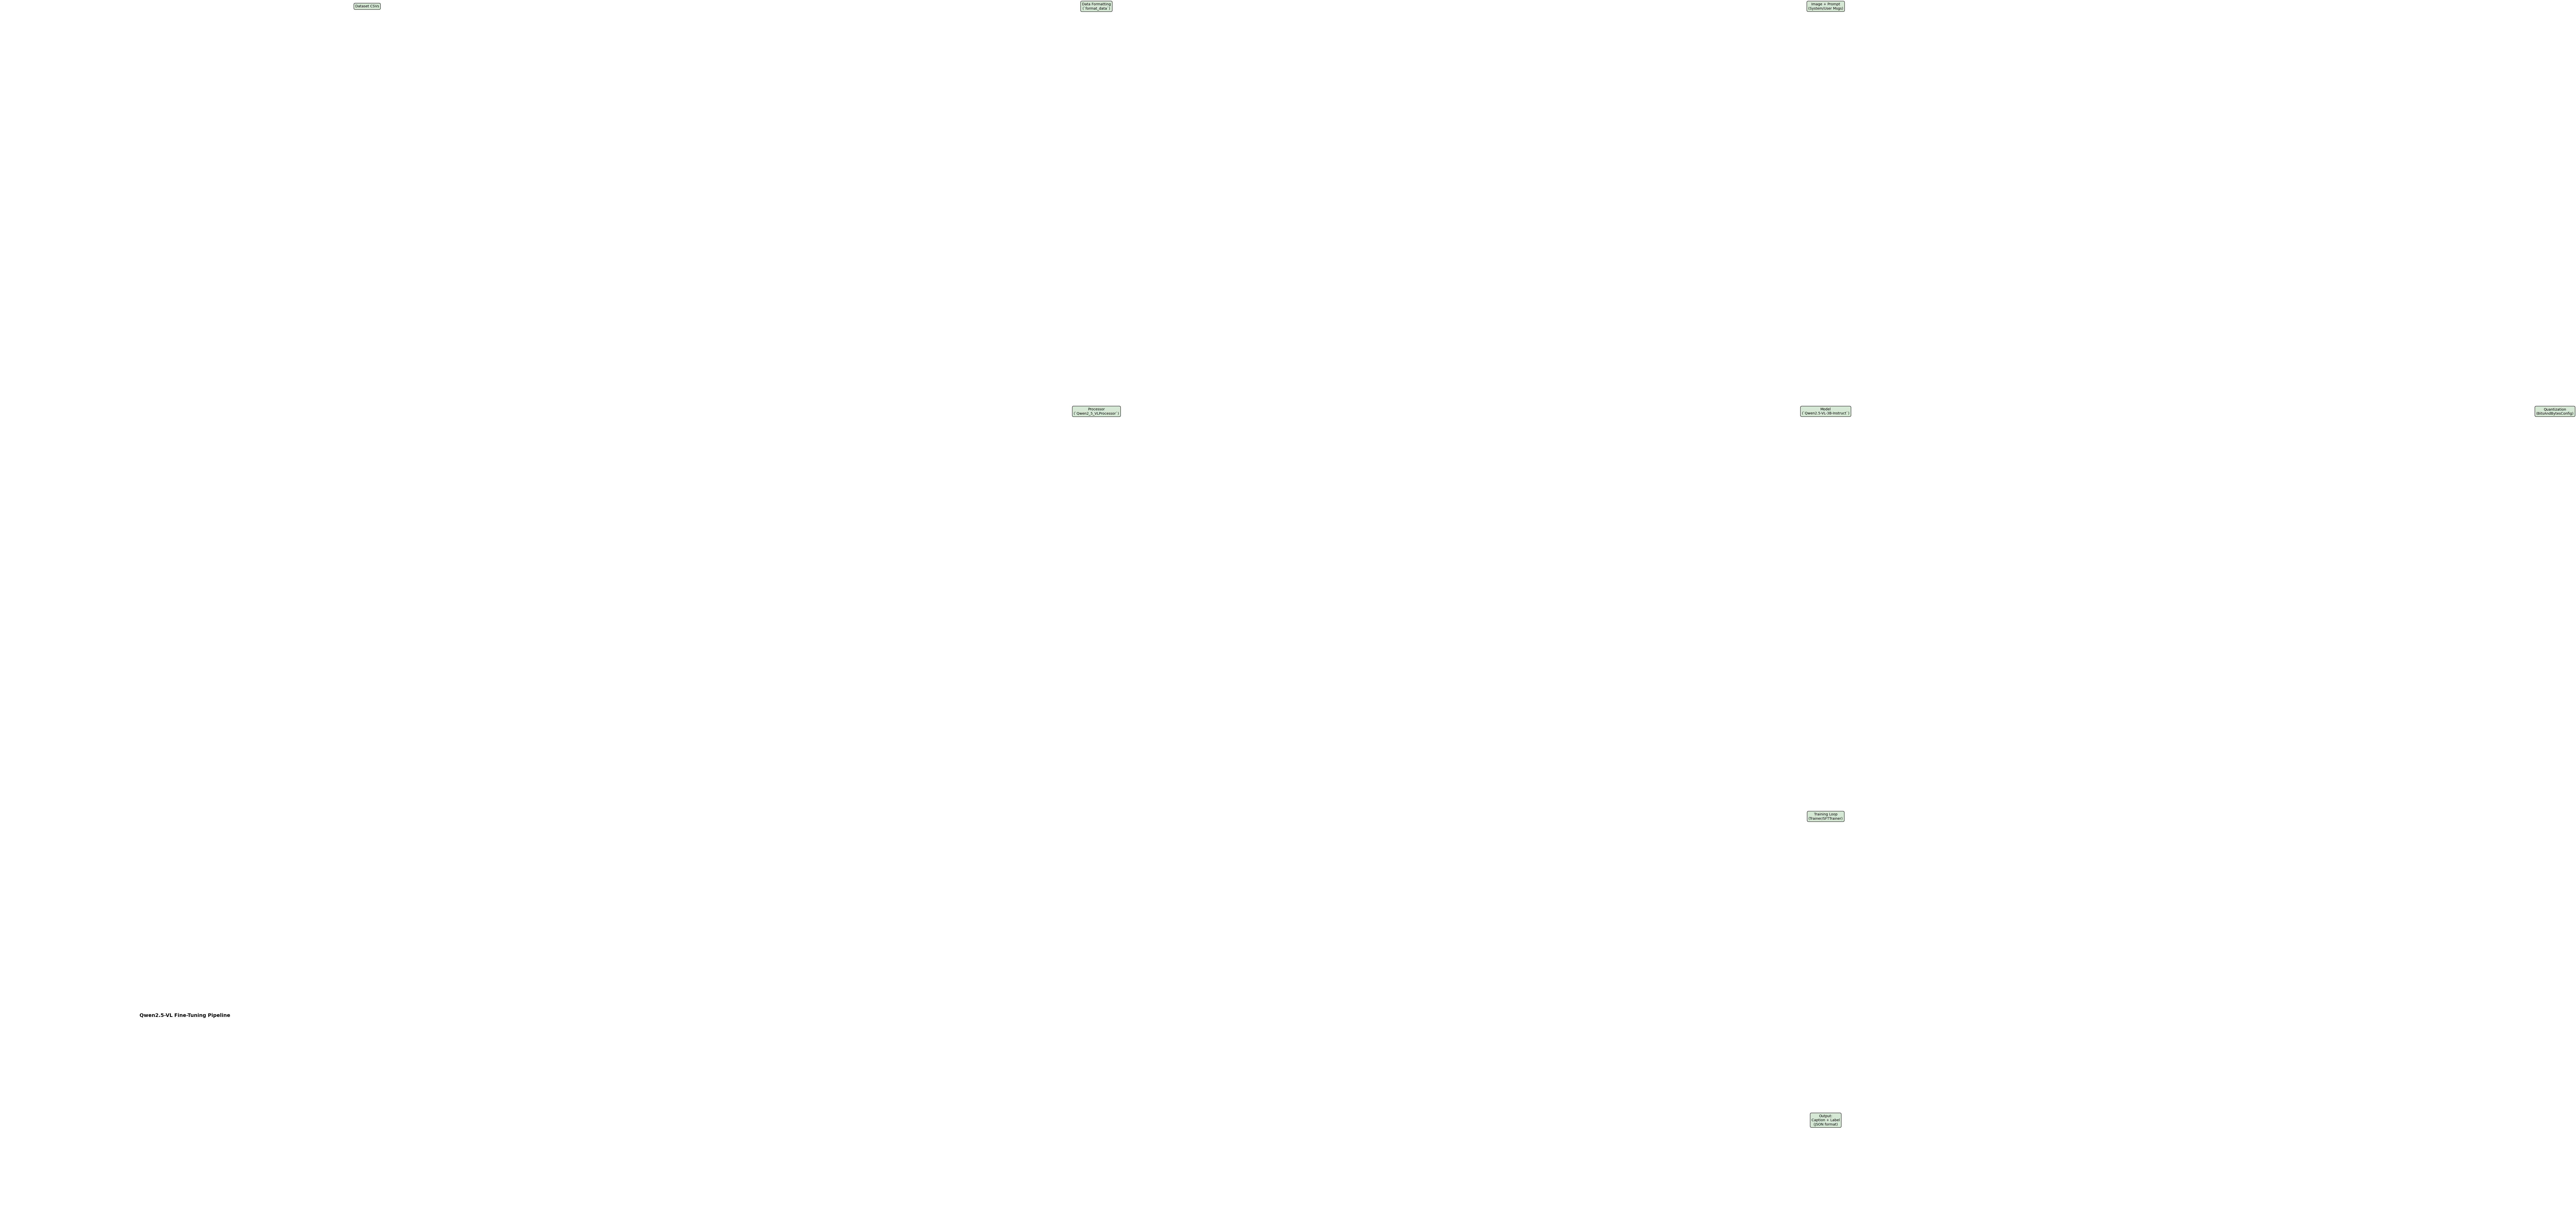

In [7]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(16, 10),squeeze=True)

# Define box style
box_style = dict(boxstyle="round,pad=0.4", facecolor="#D5E8D4", edgecolor="black")

# Define elements and their coordinates
elements = {
    "Dataset CSVs": (1, 6),
    "Data Formatting\n(`format_data`)": (3, 6),
    "Image + Prompt\n(System/User Msgs)": (5, 6),
    "Processor\n(`Qwen2_5_VLProcessor`)": (3, 4),
    "Model\n(`Qwen2.5-VL-3B-Instruct`)": (5, 4),
    "Quantization\n(BitsAndBytesConfig)": (7, 4),
    "Training Loop\n(Trainer/SFTTrainer)": (5, 2),
    "Output:\nCaption + Label\n(JSON format)": (5, 0.5)
}

# Draw elements
for text, (x, y) in elements.items():
    ax.text(x, y, text, ha="center", va="center", bbox=box_style, fontsize=10)

# Draw arrows between steps
connections = [
    ("Dataset CSVs", "Data Formatting\n(`format_data`)"),
    ("Data Formatting\n(`format_data`)", "Image + Prompt\n(System/User Msgs)"),
    ("Image + Prompt\n(System/User Msgs)", "Model\n(`Qwen2.5-VL-3B-Instruct`)"),
    ("Processor\n(`Qwen2_5_VLProcessor`)", "Model\n(`Qwen2.5-VL-3B-Instruct`)"),
    ("Quantization\n(BitsAndBytesConfig)", "Model\n(`Qwen2.5-VL-3B-Instruct`)"),
    ("Model\n(`Qwen2.5-VL-3B-Instruct`)", "Training Loop\n(Trainer/SFTTrainer)"),
    ("Training Loop\n(Trainer/SFTTrainer)", "Output:\nCaption + Label\n(JSON format)")
]

for src, dst in connections:
    x1, y1 = elements[src]
    x2, y2 = elements[dst]
    ax.annotate("", xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle="->", lw=2))

ax.set_title("Qwen2.5-VL Fine-Tuning Pipeline", fontsize=14, weight="bold")
ax.axis("off")
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1)
plt.savefig("pipeline.png")


In [ ]:
from graphviz import Digraph

dot = Digraph(comment="Qwen2.5-VL Fine-Tuning Pipeline")

# Set node shape globally (optional alternative to setting per node)
dot.attr('node', shape='box')

# Nodes
dot.node("A", "Dataset CSVs\n(ConFire as train.csv, Home-fire-dataset as val.csv, FireNet as test.csv)")
dot.node("B", "Data Formatting\n Build conversation with text + image inputs and expected output")
dot.node("C", "Image + Prompt\n(System + User Msg)")
dot.node("D", "Processor\n(Qwen2_5_VLProcessor)")
dot.node("E", "Model\n(Qwen2.5-VL-3B-Instruct)")
dot.node("F", "Quantization\n(BitsAndBytesConfig)")
dot.node("G", "Training Loop\n(SFTTrainer or Trainer)")
dot.node("H", "Output JSON\n{caption, label}")

# Edges
dot.edges([("A", "B"), ("B", "C")])
dot.edge("C", "E")
dot.edge("D", "E", label="input processor")
dot.edge("F", "E", label="optional 4-bit quant")
dot.edge("E", "G")
dot.edge("G", "H")

# Render or view
dot.render("qwen2_5vl_finetune_pipeline.gv", view=True)


'qwen2_5vl_finetune_pipeline.gv.pdf'

In [12]:
from graphviz import Digraph

dot = Digraph(comment="Qwen2.5-VL Fine-Tuning Pipeline")

# Use box shapes for clarity
dot.attr('node', shape='box', style='filled', fillcolor='lightgrey')

# Nodes with specific details from the notebook
dot.node("A", "Dataset CSVs\nConFire (train), Home-fire-dataset (val), FireNet (test)")
dot.node("B", "Data Formatting\nformat_data()\n→ multimodal chat samples")
dot.node("C", "Image + Prompt\nSystem + User messages")
dot.node("D", "Processor\nQwen2_5_VLProcessor")
dot.node("E", "Base Model\nQwen2.5-VL-3B-Instruct\n(torch.bfloat16, device_map='auto')")
dot.node("F", "Quantization (optional)\nBitsAndBytesConfig\n4-bit NF4, double quant, bfloat16 compute")
dot.node("X", "PEFT: LoRA\nr=8, α=16, dropout=0.05\nmodules=['q_proj','v_proj']")
dot.node("G", "Training Loop (SFTTrainer)\noutput_dir='qwen2-7b-instruct-trl-sft'\nEpochs=1, BS=1+accum=2\nLR=2e-4, optimizer=adamw_torch_fused\nconstant scheduler, grad_ckpt\nlogging_steps=200, max_grad_norm=0.3, warmup=0.03")
dot.node("H", "Adapter Checkpoint\ntrainer.save_model(output_dir)")

# Edges
dot.edge("A", "B")
dot.edge("B", "C")
dot.edge("C", "E")
dot.edge("D", "E", label="processor input")
dot.edge("F", "E", label="optional quantization")
dot.edge("X", "E", label="inject LoRA adapters")
dot.edge("E", "G")
dot.edge("G", "H")

# Render
dot.render("qwen2_5vl_pipeline_lora.gv", view=True)


'qwen2_5vl_pipeline_lora.gv.pdf'

In [30]:
from graphviz import Digraph

dot = Digraph(comment="Qwen2.5-VL Fine-Tuning Pipeline")

# Global node style
dot.attr('node', shape='box', style='filled', fillcolor='lightgrey')

# Data prep nodes
dot.node("A", "Dataset CSVs\nConFire (train), Home-fire-dataset (val), FireNet (test)",fillcolor="#AED6F1")
dot.node("B", "Data Formatting\nformat_data()\n→ multimodal chat samples",fillcolor="#AED6F1")
# Node C: concrete chat sample, left‑justified with \l
chat_label = (
    "[{'role': 'user',\\l"
    "  'content': [\\l"
    "    {'type': 'image', 'image': 'con_fire/train_1.jpg'},\\l"
    "    {'type': 'text', 'text': 'Summarize this situation in the image, look for signs of fire and smoke...\\l"
    "{'role': 'assistant',\\l"
    "  'content': [\\l"
    "    {'type': 'text', 'text': '```json\\l"
    "\t\t{\"caption\": \"The image shows a computer setup...\", \"label\": \"controlled fire\"}\\l"
    "```'}\\l"
    "  ]\\l"
    "}]"
)

dot.node("C", chat_label, labeljust="l", nojustify="true",fillcolor="#AED6F1")

# Grouped section: model & config
with dot.subgraph(name='cluster_model') as c:
    c.attr(label="Model & Adapter Configuration", color="black", style="rounded,filled", fillcolor="white")
    c.node_attr.update(style='rounded', fillcolor='#E8F1F2')
    c.node("D", "Processor\nQwen2_5_VLProcessor")
    c.node("E", "Base Model\nQwen2.5-VL-3B-Instruct\n(torch.bfloat16, device_map='auto')",fillcolor="#ABEBC6")
    c.node("F", "Quantization\nBitsAndBytesConfig\n4-bit NF4, double quant, bfloat16 compute",fillcolor="#ABEBC6")
    c.node("X", "PEFT: LoRA\nr=8, α=16, dropout=0.05\nmodules=['q_proj','v_proj','vision_tower]",fillcolor="#ABEBC6")

# Training & output
dot.node("G", "Training Loop (SFTTrainer)\nEpochs=5, BatchSize=2\n LR=2e-4, optimizer=adamW\n cosine LR scheduler\nlogging_steps=50, max_grad_norm=0.3, warmup=0.03",fillcolor="#F5B041")
dot.node("H", "Save Adapter\nSave as an adapter folder",fillcolor="#BB8FCE")

# 4. Adapter loading & final
dot.node("I", "Load Adapter\nmodel.load_adapter(adapter_folder)",fillcolor="#F9E79F")
dot.node("J", "Fine-Tuned Qwen2.5-VL-3B-Instruct Model\nready for inference",fillcolor="#F9E79F")

# 5. Duplicate Base Model at bottom-left
dot.node("E2", "Base Model\nQwen2.5-VL-3B-Instruct")

# Edges
# Colored edges
dot.edge("A", "B", color="#5D6D7E")
dot.edge("B", "C", color="#5D6D7E")
dot.edge("C", "D", color="#5D6D7E")
dot.edge("D", "E", label="processing inputs", color="#1B4F72")
dot.edge("F", "E", label="quantization", color="#1B4F72")
dot.edge("X", "E", label="inject LoRA", color="#148F77")
dot.edge("E", "G", color="#7D3C98")
dot.edge("G", "H", color="#7D3C98")
dot.edge("H", "I", color="#196F3D")
dot.edge("E2", "I", color="#196F3D")
dot.edge("I", "J", color="#7D6608")

# Render or view
dot.render("qwen2_5vl_pipeline_simplified.gv", view=True)

'qwen2_5vl_pipeline_simplified.gv.pdf'